# Computer Vision Nanodegree

## Project: Image Captioning (add-on)

In this notebook, we will validate our trained CNN-RNN model in single-step mode on the 2014 COCO validation dataset (s. [COCO dataset](http://cocodataset.org/#home)) using both argmax and beam search to generate image captions on single images. The predicted image captions using argmax search and beam search for inference are compared to one another and to the original ground truth image caption provided by the validation dataset.

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Get Data Loader for Validation Dataset (using Single-step Mode)
- [Step 2](#step2): Load Trained Models
- [Step 3](#step3): Finish the Sampler
- [Step 4](#step4): Clean up Captions
- [Step 5](#step5): Generate Predictions using Argmax and Beam Search!
- [Step 6](#step6): Results and Discussion


### Encoder CNN - Decoder RNN

Setup of the Encoder-Decoder-Network:
- The Encoder CNN is fed with a batch of transformed and normalized 224 x 224 color images. It returns a tensor containing a batch of embedded features, which the Encoder CNN has detected in each image. Each row of this tensor is the first embedded word that is input to the Decoder RNN to generate a of image captions
- The Decoder RNN works in cycles. It gets a batch of embedded image features as input to generate a batch of image caption sequences. Each time step the Decoder RNN produces an output tensor that contains a batch of the next predicted words for each image caption sequence in the batch. The embeddings of this predictions are fed back to the hidden LSTM layers via the hidden states.
- When performing inference we use batch_size == 1 and look at the final output of the Decoder RNN at each time step chosing the most likely next word. There are different methods to pick the most likely next words: For instnace, we can use argmax method or beam search method. In the following I compare an implementation of both methods against one another on some sample images from COCO 2014 validation dataset (s. [COCO dataset](http://cocodataset.org/#home)).

![Encoder-Decoder](images/encoder-decoder.png)

## Argmax Search

The final decoder layer of the Decoder RNN (s. [model.py](model.py)) produces a tensor of predicted word scores of size [batch_size, vocab_size] as output, where batch_size == 1 and vocab_size is the size of the trained vocabulary of the training dataset. The argmax() method just picks the highest ranked predicted word along axis dimension dim=1, which is the "vocabulary axis". It does not matter if the Decoder RNN uses softmax() or not. The result is the same.

## Beam Search

An alternative approach to argmax search is beam search. Inspired by the very interesting work of [sgrvinod](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning) 

We use a linear layer to transform the Decoder's output into a score for each word in the vocabulary.

The straightforward – and greedy – option to choose the next predicted word from the output of the final linear layer of the Decoder RNN is argmax(), which just picks the word with the highest score as the next word. This approach max not be optimal in all cases because the rest of the sequence hinges on that first word you choose. If that choice isn't the best, everything that follows is sub-optimal. And it's not just the first word – each word in the sequence has consequences for the ones that succeed it."

It might very well happen that if you'd chosen the third best word at that first step, and the second best word at the second step, and so on... that would be the best sequence you could generate.

It would be best if we could somehow not decide until we've finished decoding completely, and choose the sequence that has the highest overall score from a basket of candidate sequences.

Therefore, [sgrvinod](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning) proposes a Beam Search approach, which does exactly this.

- At the first decode step, consider the top k predicted word candidates.
- Generate k different second word candidates for each of these k first words (by looking at the top k * k ranked words, chosing the k different ones and omitting all duplicates).
- Choose the top k [first word, second word] combinations considering additive scores normalized by the sequence length to penalize for too long sequences e. g. with repetitions of words.Choose the top k [first word, second word] combinations considering additive scores.
- For each of these k second words, choose k third words, choose the top k [first word, second word, third word] combinations (s. above).
- Repeat at each decode step.
- After k sequences terminate, choose the sequence with the best overall score.
- Stop each sequence resp. caption sentence if <stop> is reached or max_len is reached.
- Terminate each sequence with the <stop> word as last word.


![Beam Search](images/beam_search.png)

Original source: [sgrvinod](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning)

<a id='step1'></a>
## Step 1: Get Data Loader for Validation Dataset (using Single-step Mode)


In [1]:
# Import required packages
import os
import torch
import torch.nn as nn
from torchvision import transforms
import torch.utils.data as data

import sys
#sys.path.append('/opt/cocoapi/PythonAPI')
sys.path.append('/home/andreas/data/coco/cocoapi/PythonAPI')
from pycocotools.coco import COCO

from data_loader_train_val_test import get_loader
from model import EncoderCNN, DecoderRNN

import math
import numpy as np
import requests
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Data loader settings => Reload validation dataset with batch_size == 1
batch_size = 1                                       # batch size (default = 1 for testing)
vocab_threshold = 5                                  # minimum word count threshold
vocab_from_file = True                               # if True, load existing vocab file (use trained vocabulary)

# Define image transform for validation
transform_val = transforms.Compose([ 
    transforms.Resize((224,224)),                    # resize both edges of the image to 224 accepting distortion
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build validation data loader using single-step validation mode.
data_loader = get_loader(transform=transform_val,         # Use image transform for validation
                         mode='single-val',               # Use single-step validation mode
                         batch_size=batch_size,           # Use default batch_size == 1 for testing
                         vocab_threshold=vocab_threshold, # Keep vocab_threshold
                         vocab_from_file=True)            # True: load existing training vocabulary

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

Data loader called in single-val-mode.
Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...


  0%|          | 815/202654 [00:00<00:24, 8144.36it/s]

Done (t=0.28s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 202654/202654 [00:21<00:00, 9571.54it/s] 


<a id='step2'></a>
## Step 2: Load Trained Models


In [3]:
# Watch for any changes in model.py, and re-load it automatically.
%load_ext autoreload
%autoreload 2

# Reload model hyperparameters
batch_size = 64                      # batch size (16...64)
#batch_size = 32                      # batch size (16...64)
#embed_size = 256                     # dimensionality of image and word embeddings
embed_size = 512                     # dimensionality of image and word embeddings
hidden_size = 512                    # number of features in hidden state of the RNN decoder
#num_lstm_layers = 1                  # number of lstm layers in the RNN decoder
num_lstm_layers = 2                  # number of lstm layers in the RNN decoder

# Specify the saved models to load.
#encoder_file = 'encoder-5_1.pkl'
#decoder_file = 'decoder-5_1.pkl'
encoder_file = 'encoder-10_2.pkl'
decoder_file = 'decoder-10_2.pkl'

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval() # Activate eval()-mode (switch off dropout)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers=num_lstm_layers)
decoder.eval() # Activate eval()-mode (switch off dropout)

# Load best models from checkpoint
print('Load trained encoder and decoder models from checkpoint...')

# Print encoder hyperparameters:
print('\n\nEncoderCNN hyperparameters:\n')
print('embed_size = ', embed_size)

# Print encoder structure
print('\n\nEncoderCNN structure:\n')
print(encoder)
print(' ')

# Print encoder hyperparameters
print('\n\nDecoderRNN hyperparameters:\n')
print('embed_size = ', embed_size)
print('hidden_size = ', hidden_size)
print('vocab_size = ', vocab_size)
print('num_layers = ', num_lstm_layers)

# Print decoder structure
print('\n\nDecoderRNN structure:\n')
print(decoder)
print(' ')

# Check for availability of CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('\nDevice: ', device, '\n')
    
# Set up filepath to model checkpoints
print('\nLoad encoder and decoder weights from hand-selected checkpoint...')
encoder_filepath = os.path.join('./models', encoder_file)
decoder_filepath = os.path.join('./models', decoder_file)
print('Load encoder weights from: {}'.format(encoder_filepath))
print('Load decoder weights from: {}'.format(decoder_filepath))

# Load the trained weights resp. the state dictionaries of encoder and decoder mapping the location 
# to the current device. This is necessary when the models have been saved on cuda but are loaded 
# on cpu (if cuda is not available).
encoder.load_state_dict(torch.load(encoder_filepath, map_location=device))
decoder.load_state_dict(torch.load(decoder_filepath, map_location=device))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)
print('\nModels moved to device and ready for validation ...\n')

Load trained encoder and decoder models from checkpoint...


EncoderCNN hyperparameters:

embed_size =  512


EncoderCNN structure:

EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1,


Models moved to device and ready for validation ...



<a id='step3'></a>
## Step 3: Finish the Sampler

Before performing validation, a `sample` method needs to be implemented in the `DecoderRNN` class in **model.py**.  This method should accept as input a PyTorch tensor `features` containing the embedded input features corresponding to a single image.

It should return as output a Python list `output`, indicating the predicted sentence.  `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence.  The correspondence between integers and tokens can be explored by examining either `data_loader.dataset.vocab.word2idx` (or `data_loader.dataset.vocab.idx2word`).

After implementing the `sample` method, run the code cell below for testing. 

Inspired by [sgrvinod](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning), two different methods have been implemented for comparision, namely:
- argmax search  
- beam search  

where beam search uses nn.functional.softmax() to normalize the predicted word scores.

In [4]:
# Get trained index-to-word dictionary from current data loader to translate tokenized words of image caption
idx2word = dict(list(data_loader.dataset.vocab.idx2word.items())[:])
dict(list(idx2word.items())[:10])

{0: '<start>',
 1: '<end>',
 2: '<unk>',
 3: 'a',
 4: 'very',
 5: 'clean',
 6: 'and',
 7: 'well',
 8: 'decorated',
 9: 'empty'}

In [5]:
# Obtain a (original image, transformed image, caption) tuple from single-step validation data loader
orig_image, image, caption = next(iter(data_loader))

# Convert tensors to numpy arrays
orig_image = orig_image[0].numpy()
transformed_image = image[0].numpy() # make a copy as image-tensor is needed as input for prediction
caption = caption[0].numpy()

# Translate tokenized image caption to words omitting special words {0: '<start>', 1: '<end>', 2: '<unk>'}
caption_in_words = []
caption_in_words.extend([idx2word[idx] for idx in caption if idx not in [0, 1, 2]])
# Join the translated words to form a caption sentence
caption_sentence = " ".join(caption_in_words)
# Capitalize first charactere in sentence
caption_sentence = caption_sentence.capitalize()
print(caption)
print(caption_in_words)
print(caption_sentence)

[   0  169   77  929 1016   53   54    3  228   33  128    3 1321   18
    1]
['man', 'in', 'tan', 'suit', 'walking', 'down', 'a', 'city', 'street', 'lighting', 'a', 'cigarette', '.']
Man in tan suit walking down a city street lighting a cigarette .


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


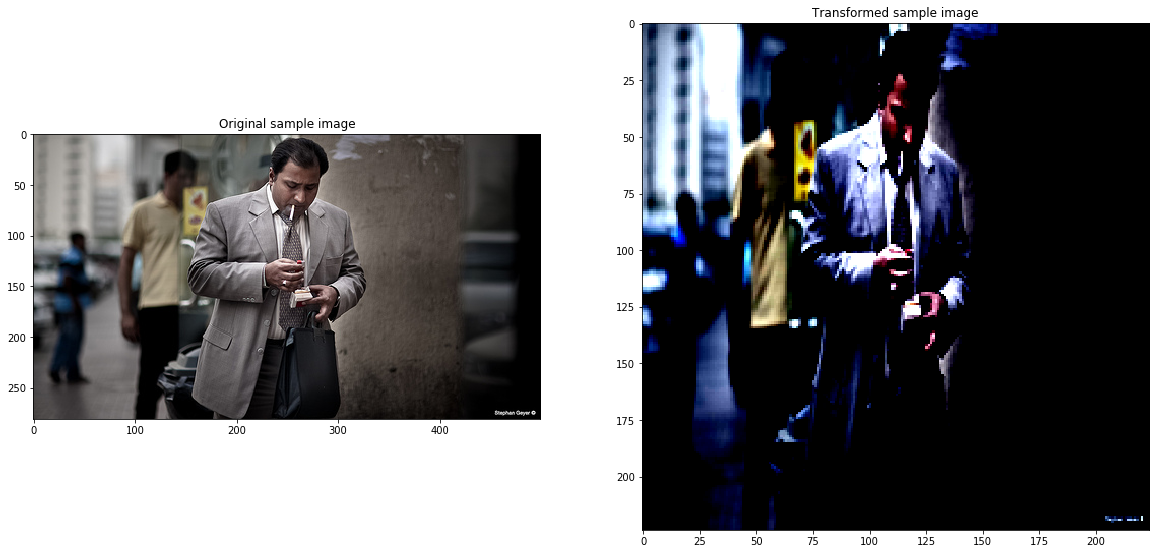

Man in tan suit walking down a city street lighting a cigarette .


In [6]:
# Visualize both original sample image before pre-processing and transformed sample image after pre-processing.
plt.figure(figsize=(20,10)) # set width and height of the figure to 20 x 10 inches
plt.subplot(121)
plt.imshow(orig_image)
plt.title('Original sample image')
plt.subplot(122)
plt.imshow(np.transpose(transformed_image, (1, 2, 0))) # transpose image swapping color channel to the back
plt.title('Transformed sample image')
plt.show()

print(caption_sentence)

In [7]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Get index for the stop word from the vocabulary
# stop_idx = data_loader.dataset.vocab.word2idx[data_loader.dataset.vocab.end_word]

# Make sure to switch off gradients for more efficient processing
with torch.no_grad():
    # Obtain the embedded image features from the Image EncoderCNN and add another dimension for sequence length
    # Obtain features.shape = [batch_size, embed_size] => New feature.shape = [batch_size, seq_len, embed_size]
    features = encoder(image)
    
    # Pass the embedded image features through the model to get a predicted caption using argmax and beamsearch.
    # output = decoder.argmax_sample(features, stop_idx=stop_idx)
    output_a = decoder.argmax_sample(features) # use argmax search method
    output_b = decoder.beamsearch_sample(features, beam_size=9, show_alternatives=1) # use beam search method
    print('example output (argmax):', output_a)
    print('example output (beamserach):', output_b)

# Check output using argmax
assert (type(output_a)==list), "Output_a needs to be a Python list" 
assert all([type(x)==int for x in output_a]), "Output_a should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output_a]), "Each entry in the output_a needs to correspond to an integer that indicates a token in the vocabulary."
# Check output using beamsearch
assert (type(output_b)==list), "Output_b needs to be a Python list" 
assert all([type(x)==int for x in output_b]), "Output_b should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output_b]), "Each entry in the output_b needs to correspond to an integer that indicates a token in the vocabulary."

Show alternatives:
Complete sequence scores      =  [[8.468101501464844], [9.458291053771973], [10.25772762298584], [11.358295440673828], [11.532607078552246], [11.532602310180664], [11.596477508544922], [12.619217872619629]]
Normalized compl. seq. scores =  [0.6513924231896033, 0.6755922181265694, 0.683848508199056, 0.7098934650421143, 0.6783886516795439, 0.6407001283433702, 0.6103409215023643, 0.6309608936309814]
Complete sequences            =  [[0, 3, 60, 6, 20, 26, 13, 3, 169, 507, 3, 1016, 1], [0, 3, 60, 6, 20, 26, 13, 3, 169, 507, 3, 1016, 18, 1], [0, 3, 60, 6, 20, 26, 13, 3, 169, 507, 3, 1016, 6, 1319, 1], [0, 3, 60, 6, 20, 26, 13, 3, 169, 507, 3, 1016, 6, 1319, 18, 1], [0, 3, 60, 6, 20, 26, 13, 3, 169, 507, 3, 1016, 6, 2197, 1319, 18, 1], [0, 3, 60, 6, 20, 26, 13, 3, 169, 507, 3, 1016, 6, 2197, 1319, 18, 18, 1], [0, 3, 60, 6, 20, 26, 13, 3, 169, 507, 3, 1016, 6, 1319, 18, 39, 3, 33, 1], [0, 3, 60, 6, 20, 26, 13, 3, 169, 507, 3, 1016, 6, 1319, 18, 39, 3, 229, 18, 1]]
example ou

<a id='step4'></a>
## Step 4: Clean up Captions for Comparing Search Methods

In the code cell below, set up the `clean_sentence` function.  It should take a list of integers resp. tokenized word indices (corresponding to the variable `output` in **Step 3**) as input, translate it into readable words using the vocabulary from the training dataset and return the corresponding predicted sentence (as a single Python string).

In [8]:
# Form clean sentences by translating the tokenized word indices in 'output' to readable words 
# using the vocabulary given by the training dataset.
def clean_sentence(output):
    # Translate the numeric tokens of the predicted caption to words using idx2word dictionary from data loader
    # while removing the first word "<start>" and the last word "<end>"
    words = [data_loader.dataset.vocab.idx2word[idx] for idx in output][1:-1]
    # Join the translated words to form a caption sentence
    sentence = " ".join(words)
    # Capitalize first charactere in sentence
    sentence = sentence.capitalize()
    # Return caption sentence
    return sentence

In [9]:
print('Ground truth image caption:            ', clean_sentence(caption))
print('Predicted image caption (argmax):      ', clean_sentence(output_a))
print('Predicted image caption (beam search): ', clean_sentence(output_b))

Ground truth image caption:             Man in tan suit walking down a city street lighting a cigarette .
Predicted image caption (argmax):       A man in a suit and tie standing in a parking lot .
Predicted image caption (beam search):  A black and white photo of a man wearing a suit and tie .


<a id='step5'></a>
## Step 5: Generate Predictions using Argmax and Beam Serach!

In the code cell below, a function (get_prediction) is defined to manually loop over images in the validation dataset and print the encoder decoder model's predicted captions using both argmax and beam search method for comparision. It also prints the ground truth caption provided by the validation dataset.

In [10]:
def compare_prediction_with_ground_truth():
    
    # Obtain a (original image, transformed image, caption) tuple from single-step validation data loader
    orig_image, image, caption = next(iter(data_loader))
    
    # Convert tensors to numpy arrays
    orig_image = orig_image[0].numpy()
    transformed_image = image[0].numpy() # make a copy as image-tensor is needed as input for prediction
    caption = caption[0].numpy()
    
    # Move image to device and pass it through the Encoder-Decoder-Chain to obtain a predicted image caption
    image = image.to(device)
    with torch.no_grad():
        # Get predict image features using the encoder CNN model
        features = encoder(image)
        
        # Predict image caption using the decoder RNN model and argmax search with default settings to chose
        # the next predicted words
        output_a = decoder.argmax_sample(features)
        
        # Predict image caption using the decoder RNN model and beam search with default settings to chose
        # the next predicted words
        output_b = decoder.beamsearch_sample(features, beam_size=9, show_alternatives=False)
        
    # Obtain translations of tokenized ground truth and predicted image captions
    original_caption = clean_sentence(caption)
    predicted_caption_a = clean_sentence(output_a)
    predicted_caption_b = clean_sentence(output_b)
    
    # Plot original and transformed sample image
    plt.figure(figsize=(20,10)) # set width and height of the figure to 20 x 10 inches
    plt.subplot(121)
    plt.imshow(orig_image)
    plt.title('Original sample image')
    plt.subplot(122)
    plt.imshow(np.transpose(transformed_image, (1, 2, 0))) # transpose image swapping color channel to the back
    plt.title('Transformed sample image')
    plt.show()
    
    # Print tokenized ground truth and predicted image caption using both argmax search and beam search
    print('Word indices of ground truth image caption:            ', caption)
    print('Word indices of predicted image caption (argmax):      ', output_a)
    print('Word indices of predicted image caption (beam search): ', output_b)
    print(' ')
    
    # Print ground truth and predicted image captions translated to words using both argmax and beam search
    print('Ground truth image caption:            ', original_caption)
    print('Predicted image caption (argmax):      ', predicted_caption_a)
    print('Predicted image caption (beam search): ', predicted_caption_b)
    print(' ')
    
    # Return predicted image captions using both argmax and beam search with the ground truth image caption
    return predicted_caption_a, predicted_caption_b, original_caption

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


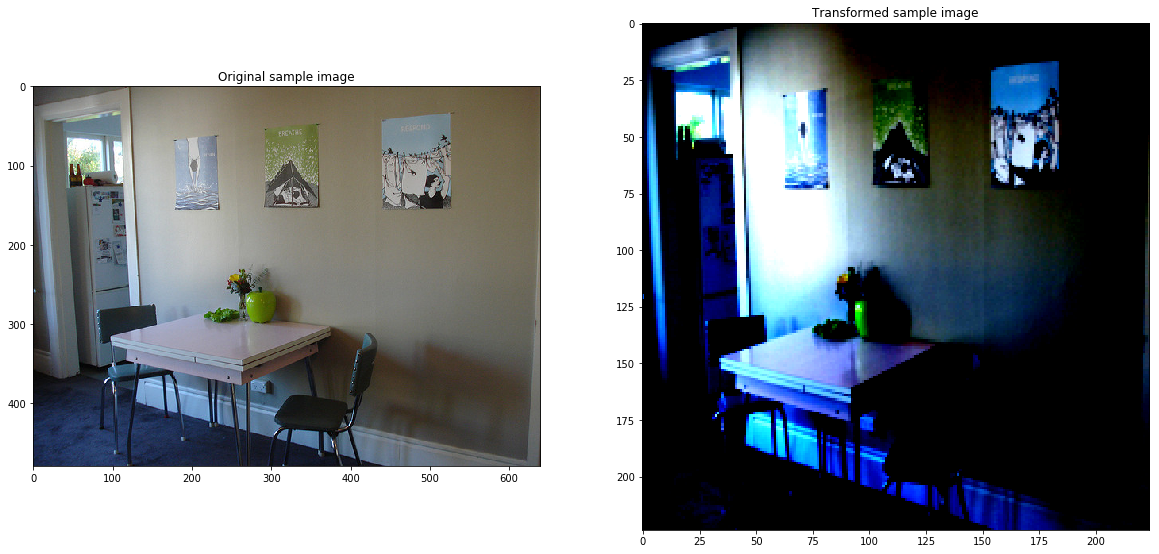

Word indices of ground truth image caption:             [  0   3  14 112  21  50 613 670   3  24  18   1]
Word indices of predicted image caption (argmax):       [0, 3, 858, 28, 21, 3, 713, 86, 873, 112, 86, 6, 624, 18, 1]
Word indices of predicted image caption (beam search):  [0, 3, 858, 28, 536, 21, 998, 6, 3, 650, 651, 233, 18, 1]
 
Ground truth image caption:             A kitchen table with two chairs against a wall .
Predicted image caption (argmax):       A living room with a couch , coffee table , and television .
Predicted image caption (beam search):  A living room filled with furniture and a flat screen tv .
 


In [11]:
_, _, _ = compare_prediction_with_ground_truth()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


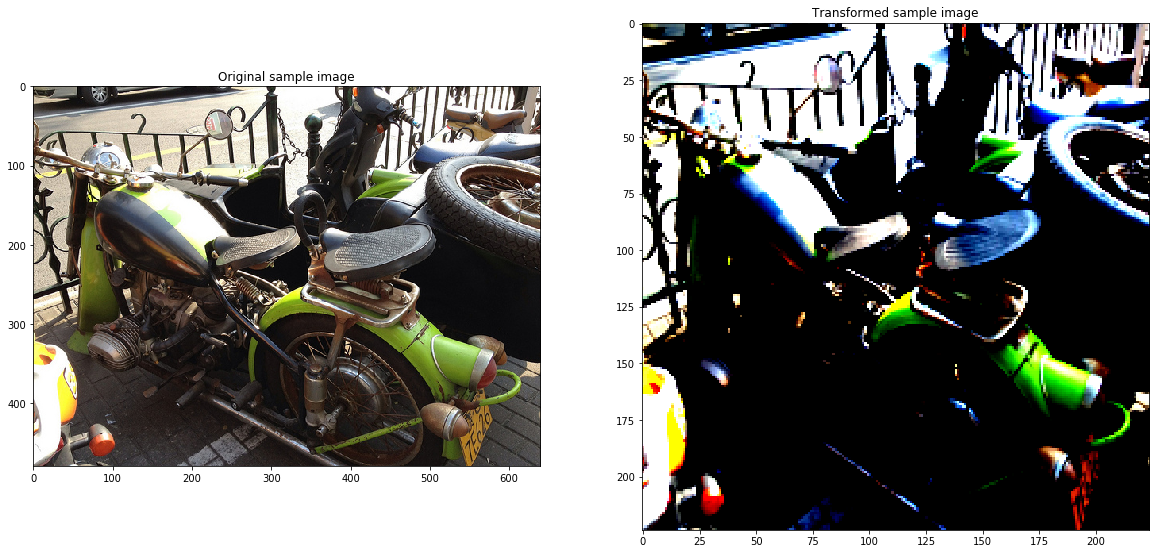

Word indices of ground truth image caption:             [  0   3 896  64 130 394 123   6 131  18   1]
Word indices of predicted image caption (argmax):       [0, 3, 896, 131, 39, 32, 185, 13, 3, 33, 18, 1]
Word indices of predicted image caption (beam search):  [0, 3, 80, 13, 1540, 131, 364, 161, 72, 409, 18, 1]
 
Ground truth image caption:             A motorcycle that is painted green and parked .
Predicted image caption (argmax):       A motorcycle parked on the side of a street .
Predicted image caption (beam search):  A group of motorcycles parked next to each other .
 


In [12]:
_, _, _ = compare_prediction_with_ground_truth()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


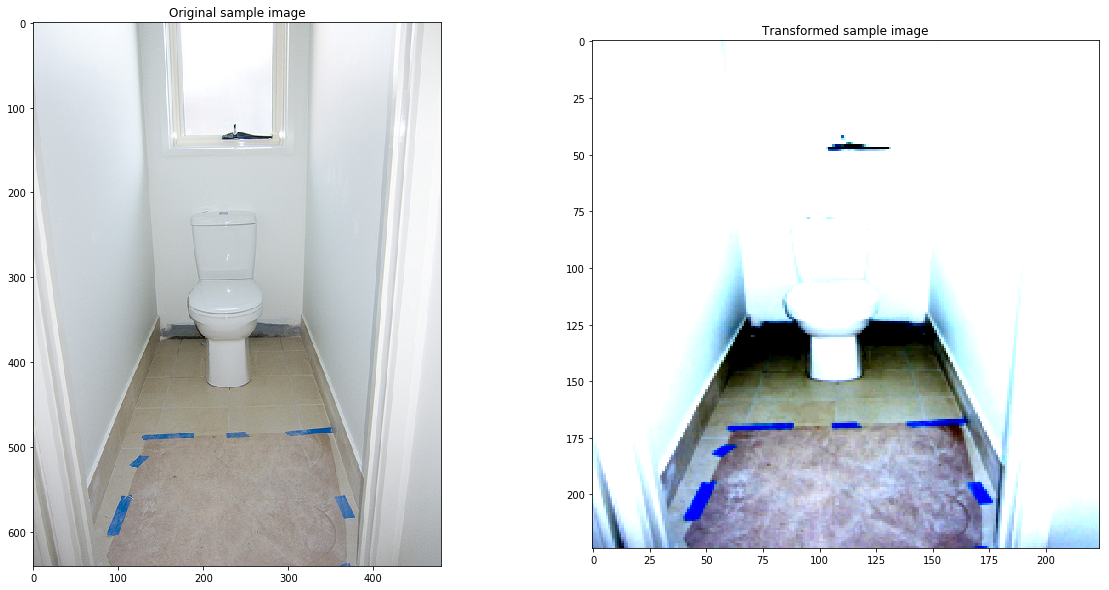

Word indices of ground truth image caption:             [  0   3  10  57  64 130 670  32  24  18   1]
Word indices of predicted image caption (argmax):       [0, 3, 10, 21, 3, 56, 86, 57, 6, 3, 151, 18, 1]
Word indices of predicted image caption (beam search):  [0, 3, 484, 28, 21, 3, 57, 3, 56, 6, 3, 152, 1]
 
Ground truth image caption:             A bathroom toilet that is against the wall .
Predicted image caption (argmax):       A bathroom with a sink , toilet and a shower .
Predicted image caption (beam search):  A bath room with a toilet a sink and a mirror
 


In [13]:
_, _, _ = compare_prediction_with_ground_truth()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


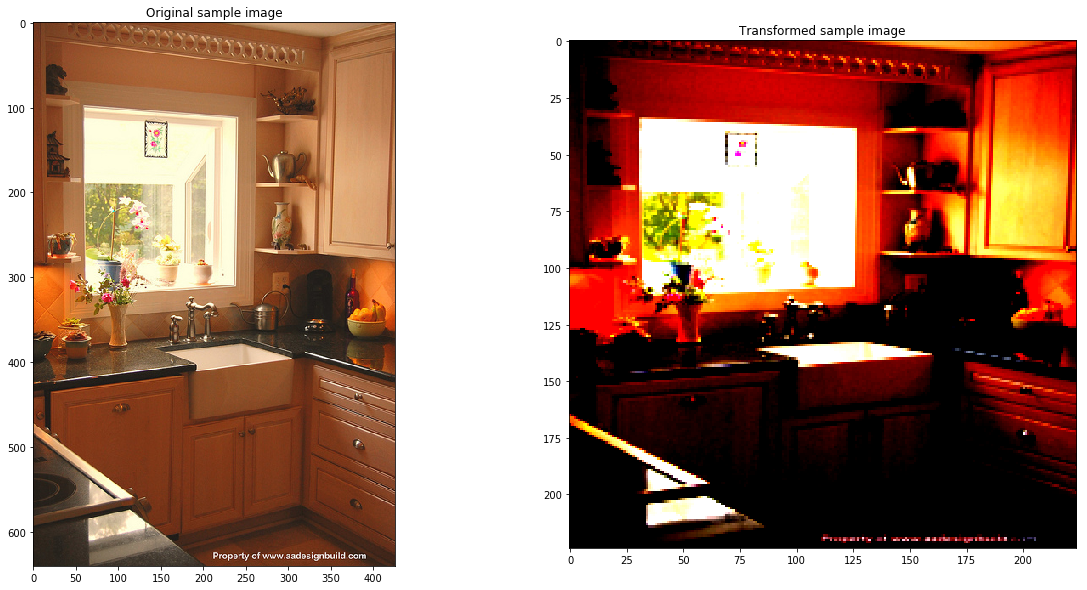

Word indices of ground truth image caption:             [  0   3  59  14  21  60  89   6   3 188 119  18   1]
Word indices of predicted image caption (argmax):       [0, 3, 14, 21, 3, 534, 86, 214, 86, 6, 3, 475, 18, 1]
Word indices of predicted image caption (beam search):  [0, 3, 14, 21, 305, 306, 17, 6, 305, 306, 17, 18, 1]
 
Ground truth image caption:             A small kitchen with black counters and a wide window .
Predicted image caption (argmax):       A kitchen with a stove , refrigerator , and a microwave .
Predicted image caption (beam search):  A kitchen with stainless steel appliances and stainless steel appliances .
 


In [14]:
_, _, _ = compare_prediction_with_ground_truth()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


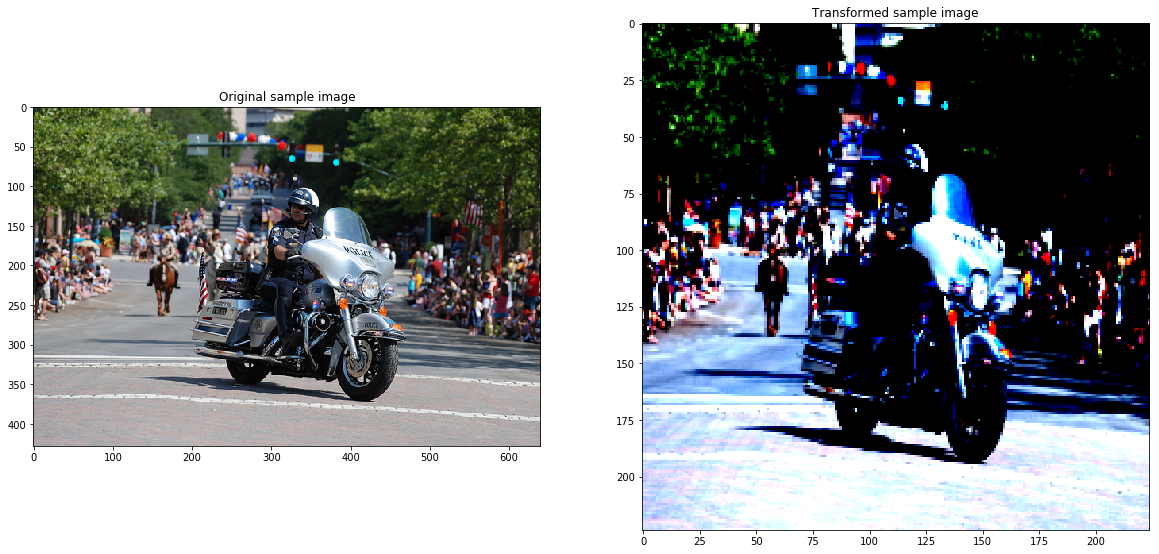

Word indices of ground truth image caption:             [   0 1287 2447   39 2957  730  674   77  228   18    1]
Word indices of predicted image caption (argmax):       [0, 3, 896, 131, 39, 32, 185, 13, 3, 40, 18, 1]
Word indices of predicted image caption (beam search):  [0, 3, 169, 139, 3, 896, 54, 3, 228, 33, 18, 1]
 
Ground truth image caption:             Motor officer on roadway during parade in city .
Predicted image caption (argmax):       A motorcycle parked on the side of a road .
Predicted image caption (beam search):  A man riding a motorcycle down a city street .
 


In [15]:
_, _, _ = compare_prediction_with_ground_truth()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


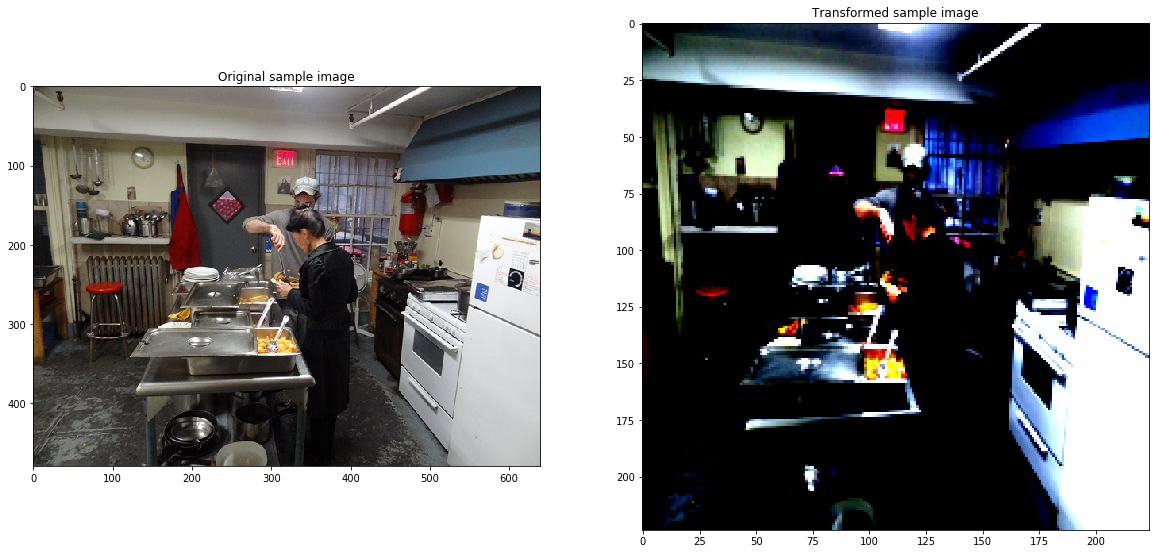

Word indices of ground truth image caption:             [  0   3 330  13  51  64  52  77   3  14   1]
Word indices of predicted image caption (argmax):       [0, 3, 14, 21, 3, 534, 6, 3, 534, 1]
Word indices of predicted image caption (beam search):  [0, 3, 12, 13, 3, 14, 21, 305, 306, 17, 18, 1]
 
Ground truth image caption:             A couple of people that are in a kitchen
Predicted image caption (argmax):       A kitchen with a stove and a stove
Predicted image caption (beam search):  A view of a kitchen with stainless steel appliances .
 


In [16]:
_, _, _ = compare_prediction_with_ground_truth()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


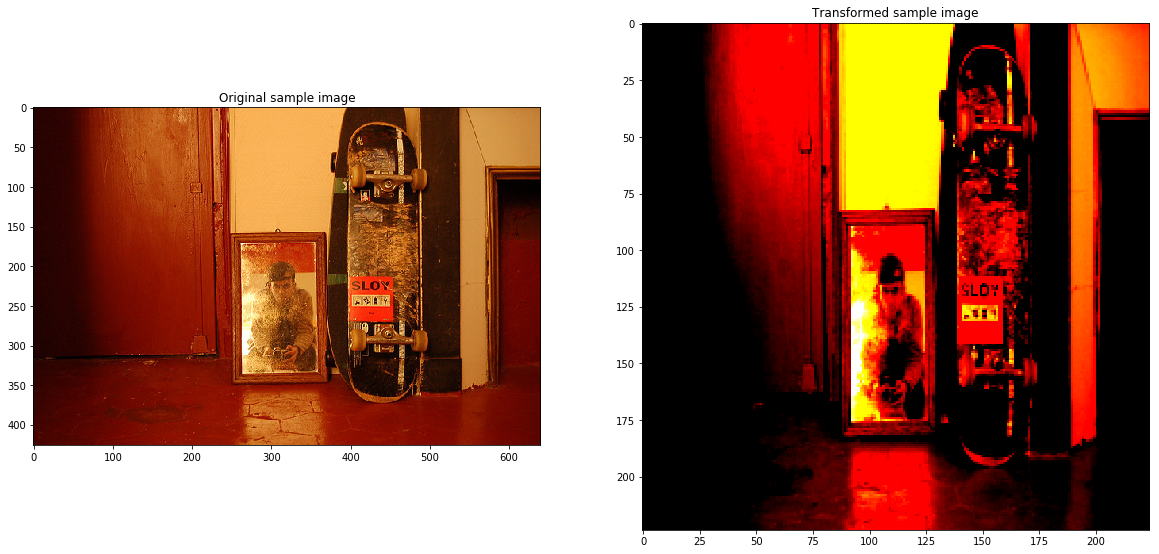

Word indices of ground truth image caption:             [  0   3 753 960 670   3  24  21   3  26 224 364 161  46  18   1]
Word indices of predicted image caption (argmax):       [0, 3, 115, 130, 224, 39, 3, 119, 1585, 18, 1]
Word indices of predicted image caption (beam search):  [0, 3, 60, 6, 20, 26, 13, 3, 858, 28, 536, 21, 998, 18, 1]
 
Ground truth image caption:             A skateboard resting against a wall with a photo sitting next to it .
Predicted image caption (argmax):       A cat is sitting on a window sill .
Predicted image caption (beam search):  A black and white photo of a living room filled with furniture .
 


In [17]:
_, _, _ = compare_prediction_with_ground_truth()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


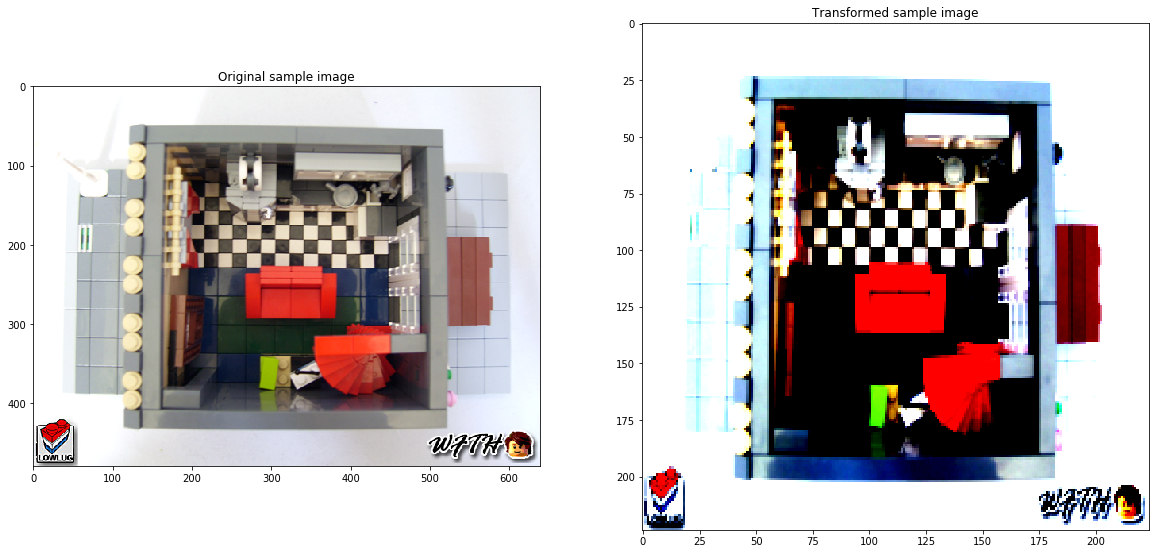

Word indices of ground truth image caption:             [   0   47 2322  405   13    3   14    6  858   28 1835   13    2    1]
Word indices of predicted image caption (argmax):       [0, 3, 14, 21, 3, 534, 6, 3, 214, 1]
Word indices of predicted image caption (beam search):  [0, 3, 858, 28, 536, 21, 998, 6, 3, 650, 651, 233, 18, 1]
 
Ground truth image caption:             An aerial shot of a kitchen and living room model of <unk>
Predicted image caption (argmax):       A kitchen with a stove and a refrigerator
Predicted image caption (beam search):  A living room filled with furniture and a flat screen tv .
 


In [18]:
_, _, _ = compare_prediction_with_ground_truth()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


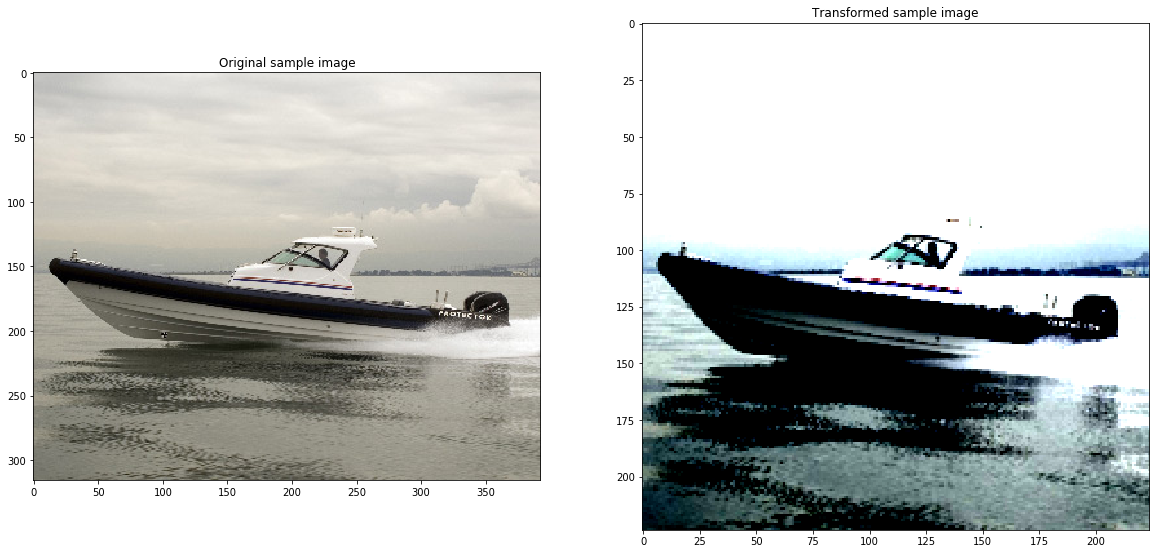

Word indices of ground truth image caption:             [   0    3   98  130  897    3 6016 1451  417   32  278   18    1]
Word indices of predicted image caption (argmax):       [0, 3, 277, 130, 1291, 77, 32, 278, 79, 3, 437, 13, 278, 18, 1]
Word indices of predicted image caption (beam search):  [0, 3, 277, 64, 130, 1291, 77, 32, 278, 364, 161, 3, 437, 13, 278, 18, 1]
 
Ground truth image caption:             A person is driving a speedboat quickly through the water .
Predicted image caption (argmax):       A boat is floating in the water near a body of water .
Predicted image caption (beam search):  A boat that is floating in the water next to a body of water .
 


In [19]:
_, _, _ = compare_prediction_with_ground_truth()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


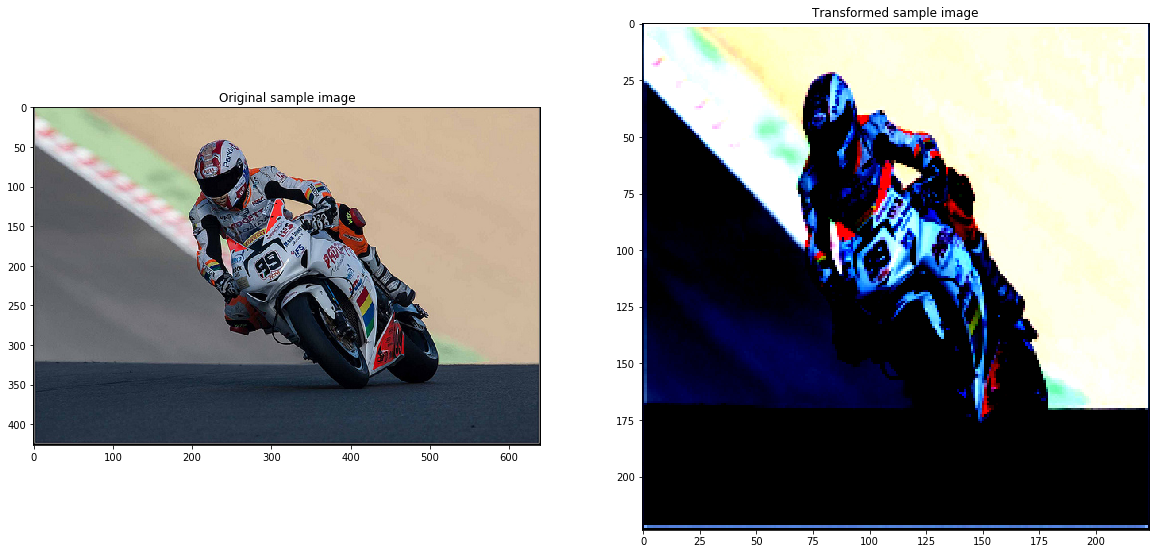

Word indices of ground truth image caption:             [   0  896 5286  221    3  876   39 1683 3452  730  703   18    1]
Word indices of predicted image caption (argmax):       [0, 3, 169, 139, 3, 896, 39, 3, 1973, 40, 18, 1]
Word indices of predicted image caption (beam search):  [0, 3, 169, 139, 3, 1973, 140, 39, 257, 13, 3, 1333, 123, 204, 18, 1]
 
Ground truth image caption:             Motorcycle racer making a turn on paved course during race .
Predicted image caption (argmax):       A man riding a motorcycle on a dirt road .
Predicted image caption (beam search):  A man riding a dirt bike on top of a lush green field .
 


In [20]:
_, _, _ = compare_prediction_with_ground_truth()

<a id='step6'></a>
## Step 6: Results and Discussion

On all tested images both argmax search and beam search method produce indentical results. As argmax search is pretty straight forward to implement this means at least that my implemented beam search is mean

### Observation
When directly implementing the beam search solution proposed by [sgrvinod](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning) with my models I always got the same results as with argmax search. There was no differentiation at all. When printing out the top k sentences stored by my first beam search implementation I realized they were all the same for any image. 
Looking closer I found the following cause: As the Decoder RNN always produces the same results when feeding it with the same word sequences it will also always produce the same k next words with the same scoring if the previous word sequences are not altered. So if there is no enforced variance we will always get the same results as with argmax. 

### Suggestion for a Modifiation
Therefore, I suggest to enforce some varience by not only taking the top k next words (k = beam size), but to look at the top k * k or k² next words. Experiments showed that there are only k different next words among the top k * k ones when the previous word sequence has been the same for all top k sentences. The word with the highest scoring, which would be taken by argmax, is also included at the highest rank. We will pick out only the k highest ranked different words by going through all of the top k * k leaving out any duplicates. So we will end up with the top k different words with the best scores, which are then fed back to the Decoder RNN for the next iteration.

When following this strategy we get indeed different sentences. However, as we use additive scoring to rank the top k sentences, longer sequences will automatically be preferred. This may lead to a '.' appearing multiple times at the end of a sentence, for instance. To overcome this problem, I suggest to normalize the additive scores for all top k sentences in the end to penalize longer sequences. This is maybe not the best solution but it does its job for now until I find a better one.

### Conclusion comparing Argmax and Beam Search
Of course, I have only not checked a few sample images from the validation dataset. In general, there are examples where the images caption seems reasonable for human reckoning and there are also examples where the prediction is complete nonesense or at least not completely correct. One reason is certainly the low number of training epochs I have used. So we can do better when training for many many more iterations including augmentation, which of course increases the costs.
When taking the current state as is, both argmax and beam search produce at least similar but different solutions in most cases. It is hard to say, which one is better. Certainly, beam search uses some more computation than argmax. As argmax is quite ok for my reckoning, I would recommend to use argmax search as a simple but efficient solution.